In [3]:
!conda activate portrait

In [5]:
!pip install scikit-learn==0.20.1 seaborn==0.9.0 matplotlib==3.5.0

  Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0


In [7]:
!pip install torch

In [9]:
!pip install torchvision

  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2


In [1]:
import os
import torch
import torchvision
import skillsnetwork

import numpy as np
import pandas as pd
import seaborn as sns 

import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from skimage import transform, io
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

sns.set_context("notebook")
sns.set_style("white")
%matplotlib inline

In [2]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

In [3]:
def f(modules_dict, x):
    
    inner_enc_layers = []
    inner_dec_layers = []
    
    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == 'd':
            inner_dec_layers.append(layer)
        else:
            inner_enc_layers.append(layer)
    
    hx = x
    hxin = inner_enc_layers[0](hx)
    hx = hxin
    inner_enc_outputs = []
    
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)
        if not isinstance(layer, nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)
            
    hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(), inner_enc_outputs.pop()), 1))
    
    for layer in inner_dec_layers[1:]:
        hxdup = _upsample_like(hxd, inner_enc_outputs[-1])
        hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()), 1))
        
    return hxd + hxin

In [4]:
def norm_pred(d):
    
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    
    return dn

def _upsample_like(src, tar):

    src = nn.functional.upsample(src, size=tar.shape[2:], mode="bilinear")
    return src

In [5]:
class RescaleT(object):
    
    def __init__(self, output_size):
        self.output_size = output_size
    
    def __call__(self, sample):
        imidx, image = sample["imidx"], sample["image"]
        img = transform.resize(image, (self.output_size, self.output_size), mode="constant")
        return {"imidx":imidx, "image":img}
    
class ToTensor(object):
    
    def __init__(self, flag=0):
        self.flag = flag
        
    def __call__(self, sample):
        imidx, image = sample["imidx"], sample["image"]
        tempImg = np.zeros((image.shape[0], image.shape[1], 3))
        image = image / np.max(image)
        
        tempImg[:,:,0] = (image[:,:,0]-0.485)/0.229
        tempImg[:,:,1] = (image[:,:,1]-0.456)/0.224
        tempImg[:,:,2] = (image[:,:,2]-0.406)/0.225
        
        tempImg = tempImg.transpose((2,0,1))
        
        return {'imidx':torch.from_numpy(imidx), 'image':torch.from_numpy(tempImg)}
    
class REBNCONV(nn.Module):
    
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()
        
        self.conv_s1 = nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate, dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        hx = x 
        return self.relu_s1(self.bn_s1(self.conv_s1(hx)))

In [6]:
class RSU7(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [7]:
class RSU6(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [8]:
class RSU5(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        
    
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [9]:
class RSU4(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [10]:
class RSU4F(nn.Module):
    
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [11]:
class U2NET(nn.Module):
    
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NET, self).__init__()
        
        self.stage1 = RSU7(in_ch, 32, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.stage6 = RSU4F(512, 256, 512)
        
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4(1024, 128, 256)
        self.stage3d = RSU5(512, 64, 128)
        self.stage2d = RSU6(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)
        
        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(128, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(256, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(512, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(512, out_ch, 3, padding=1)
        
        self.outconv = nn.Conv2d(6*out_ch, out_ch, 1)
        
    def forward(self, x):

        hx = x

        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)
        
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        return nn.functional.sigmoid(d0)

In [12]:
net = U2NET(3, 1)
net.load_state_dict(torch.load("model/u2net.pth", map_location='cpu'))

<All keys matched successfully>

In [13]:
class LoadDataset(Dataset):
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_list = [x for x in os.listdir(img_dir) if not x.startswith(".")]
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = io.imread(img_name)
        imidx = np.array([idx])
        sample = {'imidx':imidx, 'image':image}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample  

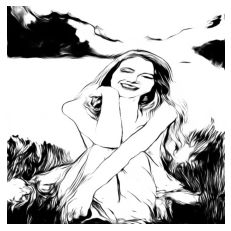

In [14]:
dataset = LoadDataset(img_dir = './images', 
                             transform = transforms.Compose([RescaleT(512),
                                                             ToTensor(0)]))

dataloader = DataLoader(dataset, batch_size=1)

for data in dataloader:
    input_image = Variable(data['image'].type(torch.FloatTensor))
    d = net(input_image)

# normalization
pred = norm_pred(1.0 - d[:,0,:,:])

predict = pred.squeeze().cpu().data.numpy()
img = Image.fromarray(predict*255).convert('RGB')

plt.imshow(np.array(img))
plt.axis("off")

del input_image, d, pred, predict, img
